In [1]:
from google.colab import drive
import os
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -U albumentations --quiet

     |████████████████████████████████| 102kB 2.5MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 


In [3]:
MODEL_SAVE_PATH = '/content/gdrive/MyDrive/esun_2021_model/' # 冠豪的模型放在這
YT_MODEL_SAVE_PATH = '/content/gdrive/MyDrive/esun_2021_model/esun_model_yt/' # 彥庭的模型放在這

In [4]:
# Test Data，直接解壓縮到 google colab 的 local 環境
# 請記得檢查路徑是否正確
!unzip -q '/content/gdrive/MyDrive/esun_2021_test_data/玉山_20210524_image_labeled.zip'
!unzip -q '/content/gdrive/MyDrive/esun_2021_test_data/快車肉乾.zip'
!unzip -q '/content/gdrive/MyDrive/esun_2021_test_data/玉山_20210525_image_labeled.zip'
!unzip -q '/content/gdrive/MyDrive/esun_2021_test_data/玉山_20210608_image_labeled.zip'

In [5]:
import pickle
import matplotlib.pyplot as plt
import re
from skimage import io
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
from torchvision import models, transforms
from PIL import Image

MODEL_SAVE_PATH = Path(MODEL_SAVE_PATH)
YT_MODEL_SAVE_PATH = Path(YT_MODEL_SAVE_PATH)
TEST_DATA_1_PATH = Path("./玉山_20210524_image_labeled")
TEST_DATA_2_PATH = Path("./快車肉乾")
TEST_DATA_3_PATH = Path("./玉山_20210525_image_labeled")
TEST_DATA_4_PATH = Path("./玉山_20210608_image_labeled")
with open(MODEL_SAVE_PATH/"training data dic.txt", "r") as f:
    VOCAB = set([x.replace("\n", "") for x in f.readlines()]) # 官方認可的 800 字

def get_character_from_path(p):
    return re.findall('\d+_(\w)\.', p.name)[0]

test_data_1 = [p for p in TEST_DATA_1_PATH.iterdir() if p.is_file()]
test_data_1 = sorted(test_data_1, key = lambda x: int(re.findall('(\d+)_', x.name)[0]))
test_data_2 = [p for p in TEST_DATA_2_PATH.iterdir() if p.is_file() and p.name.endswith("png")]
test_data_2 = sorted(test_data_2, key = lambda x: int(re.findall('(\d+)_', x.name)[0]))
test_data_3 = [p for p in TEST_DATA_3_PATH.iterdir() if p.is_file()]
test_data_3 = sorted(test_data_3, key = lambda x: int(re.findall('(\d+)_', x.name)[0]))
test_data_4 = [p for p in TEST_DATA_4_PATH.iterdir() if p.is_file()]
test_data_4 = sorted(test_data_4, key = lambda x: int(re.findall('(\d+)_', x.name)[0]))

print("測資 1：", test_data_1[:3])
print("       ", [get_character_from_path(p) for p in test_data_1][:3])
print("測資 2：", test_data_2[:3])
print("       ", [get_character_from_path(p) for p in test_data_2][:3])
print("測資 3：", test_data_3[:3])
print("       ", [get_character_from_path(p) for p in test_data_3][:3])
print("測資 4：", test_data_4[:3])
print("       ", [get_character_from_path(p) for p in test_data_4][:3])

測資 1： [PosixPath('玉山_20210524_image_labeled/1_委.jpg'), PosixPath('玉山_20210524_image_labeled/2_昱.jpg'), PosixPath('玉山_20210524_image_labeled/3_育.jpg')]
        ['委', '昱', '育']
測資 2： [PosixPath('快車肉乾/ch_1_親.png'), PosixPath('快車肉乾/ch_2_愛.png'), PosixPath('快車肉乾/ch_3_的.png')]
        ['親', '愛', '的']
測資 3： [PosixPath('玉山_20210525_image_labeled/1_于.jpg'), PosixPath('玉山_20210525_image_labeled/2_以.jpg'), PosixPath('玉山_20210525_image_labeled/3_戶.jpg')]
        ['于', '以', '戶']
測資 4： [PosixPath('玉山_20210608_image_labeled/1_文.jpg'), PosixPath('玉山_20210608_image_labeled/2_石.jpg'), PosixPath('玉山_20210608_image_labeled/3_丞.jpg')]
        ['文', '石', '丞']


## 模型測試 Function

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

## function: 預測一張 RGB 圖片
def predict_image(img, model, transform=None):
    """ 
        input: image of RGB format 
        output: tuple(predicted_index, predicted_probability)    
    """
    img = img[:,:,:3]
    h, w, c = img.shape
    if w <= 5: return -1 # 圖片太窄，直接回傳 index=-1
    if w/h >= 2: # 圖片不合理地寬，動點手腳
        img_diff_hrz = img[:, 1:,:] - img[:, :-1,:]
        img_diff_hrz_pxl = ((np.abs(img_diff_hrz) < 6).sum(axis=2) == 3) # RGB 都相同
        hrz_sum = img_diff_hrz_pxl.sum(axis=0) / h
        window_size = 5
        threshold = 0.5
        hrz_sum_window = running_mean(hrz_sum, window_size)
        kept_idx_hrz = [i+window_size for i, x in enumerate(hrz_sum_window) if x < threshold]
        if kept_idx_hrz:
            img = img[:, list(range(window_size))+kept_idx_hrz, :]
    if transform is not None: img = transform(img)
    with torch.no_grad():
        out = model.to(device).forward(img.unsqueeze(0).to(device))
        prob, pred = torch.max(torch.exp(out).to('cpu'), 1)
    return (pred.item(), prob.item())

## helper function: 預測並呈現 RGB 圖片
def predict_and_show(img, model, idx2vocab, character, transform=None):
    pred, prob = predict_image(img=img, model=model, transform=transform)
    pred_character = idx2vocab[pred]
    print(f"""
    答對了嗎： {pred_character == (character if character in VOCAB else 'isnull')},  
    預測： {pred_character} ( {prob*100:.1f} % ),  
    正解： {character} {'(isnull)' if character not in VOCAB else ''}
    """)
    plt.imshow(img)
    plt.show()
    print("\n    ---   ---   ---   ---   ---   ---   ---   ---   ---   ")

## helper function: 統計一份測資的正確率
def calculate_test_data(data, model, idx2vocab, transform=None):
    """
        input: list of image file path
        output: tuple(hit_count, all_count)
    """
    hit_count = 0
    for p in data:
        img = io.imread(p)
        pred, prob = predict_image(img=img, model=model, transform=transform)
        character = get_character_from_path(p)
        if character not in VOCAB: character = "isnull"
        pred_character = idx2vocab[pred]
        hit_count += pred_character==character
    return (hit_count, len(data))

## 冠豪的模型測試

In [25]:
## 冠豪的 Setting

HEIGHT, WIDTH = 67, 49
NORM_MEAN, NORM_STD = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
_test_transform = A.Compose(
    [
        A.Resize(always_apply=True, height=HEIGHT, width=WIDTH),
        A.Normalize(mean=NORM_MEAN, std=NORM_STD),
        ToTensorV2()
    ]
)
def test_transform(img):
    return _test_transform(image=img)['image']

with open(MODEL_SAVE_PATH/'vocab2idx.pkl', 'rb') as handle:
    vocab2idx = pickle.load(handle)
    idx2vocab = {v: k for k, v in vocab2idx.items()}
    idx2vocab[-1] = "isnull"

NUM_CLASSES = len(vocab2idx)
class EsunModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.width = WIDTH
        self.height = HEIGHT
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.fc = nn.Sequential(
            nn.Linear((512*4*3), 2048),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, NUM_CLASSES),
            nn.LogSoftmax(dim=1)
        )
        self.flatten = nn.Flatten()

    def forward(self, img):
        conv = self.conv(img)
        out = self.fc(self.flatten(conv))
        return out

model = EsunModel()
model.load_state_dict(torch.load(MODEL_SAVE_PATH/"pytorch_esun_2021_model_weights-v15.pkl"))
model.eval()

EsunModel(
  (conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

In [26]:
hit_count_1, all_count_1 = calculate_test_data(data=test_data_1, model=model, idx2vocab=idx2vocab, transform=test_transform)
hit_count_2, all_count_2 = calculate_test_data(data=test_data_2, model=model, idx2vocab=idx2vocab, transform=test_transform)
hit_count_3, all_count_3 = calculate_test_data(data=test_data_3, model=model, idx2vocab=idx2vocab, transform=test_transform)
hit_count_4, all_count_4 = calculate_test_data(data=test_data_4, model=model, idx2vocab=idx2vocab, transform=test_transform)
print(f"玉山 2021-05-24 測資\n \
        - 正確率：{hit_count_1/all_count_1*100:.1f} %  ( {hit_count_1} / {all_count_1} )")
print(f"快車肉乾 測資\n \
        - 正確率：{hit_count_2/all_count_2*100:.1f} %  ( {hit_count_2} / {all_count_2} )")
print(f"玉山 2021-05-25 測資\n \
        - 正確率：{hit_count_3/all_count_3*100:.1f} %  ( {hit_count_3} / {all_count_3} )")
print(f"玉山 2021-06-08 測資\n \
        - 正確率：{hit_count_4/all_count_4*100:.1f} %  ( {hit_count_4} / {all_count_4} )")
print(f"上述所有測資加總\n \
        - 正確率：{(hit_count_1+hit_count_2+hit_count_3+hit_count_4)/(all_count_1+all_count_2+all_count_3+all_count_4)*100:.1f} %  ( {hit_count_1+hit_count_2+hit_count_3+hit_count_4} / {all_count_1+all_count_2+all_count_3+all_count_4} )")

玉山 2021-05-24 測資
         - 正確率：94.3 %  ( 33 / 35 )
快車肉乾 測資
         - 正確率：95.4 %  ( 146 / 153 )
玉山 2021-05-25 測資
         - 正確率：100.0 %  ( 35 / 35 )
玉山 2021-06-08 測資
         - 正確率：76.7 %  ( 23 / 30 )
上述所有測資加總
         - 正確率：93.7 %  ( 237 / 253 )



    答對了嗎： True,  
    預測： 文 ( 100.0 % ),  
    正解： 文 
    


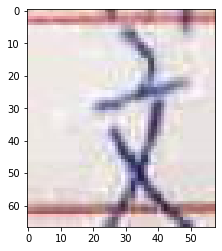


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 石 ( 100.0 % ),  
    正解： 石 
    


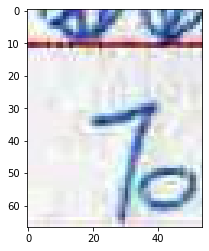


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 丞 ( 98.6 % ),  
    正解： 丞 
    


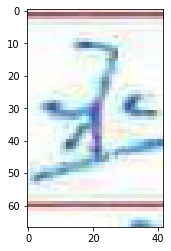


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 余 ( 100.0 % ),  
    正解： 余 
    


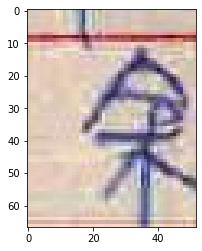


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 呂 ( 100.0 % ),  
    正解： 呂 
    


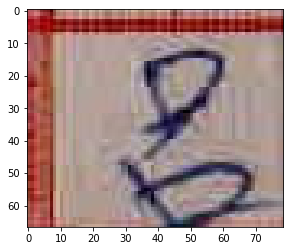


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 亞 ( 63.8 % ),  
    正解： 婭 (isnull)
    


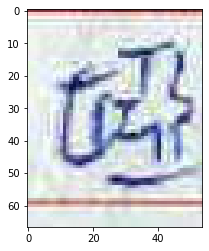


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 兒 ( 100.0 % ),  
    正解： 兒 
    


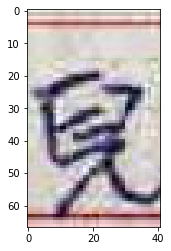


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 坤 ( 100.0 % ),  
    正解： 坤 
    


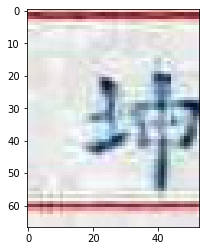


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 尚 ( 97.1 % ),  
    正解： 尚 
    


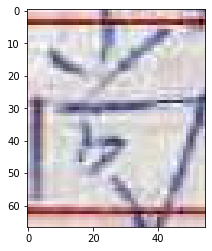


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 忠 ( 100.0 % ),  
    正解： 忠 
    


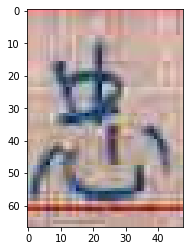


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 宥 ( 100.0 % ),  
    正解： 宥 
    


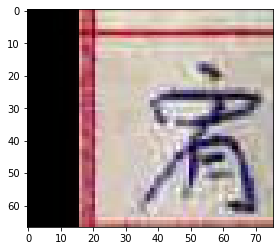


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 施 ( 49.9 % ),  
    正解： 施 
    


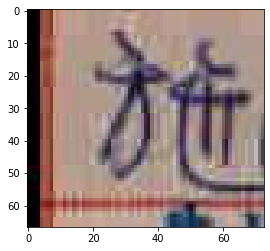


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 音 ( 87.9 % ),  
    正解： 春 
    


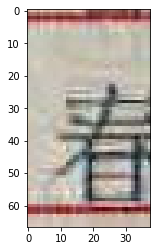


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 凌 ( 99.7 % ),  
    正解： 凌 
    


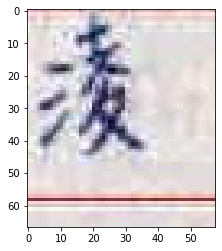


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 哲 ( 100.0 % ),  
    正解： 哲 
    


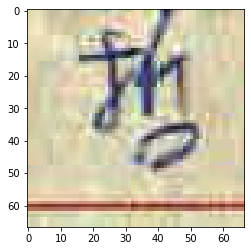


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 宸 ( 99.4 % ),  
    正解： 宸 
    


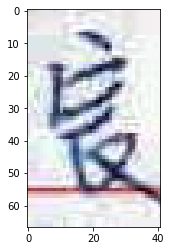


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 敏 ( 99.8 % ),  
    正解： 敏 
    


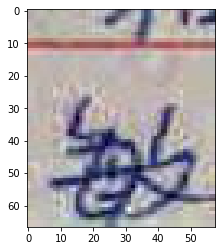


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 許 ( 99.6 % ),  
    正解： 許 
    


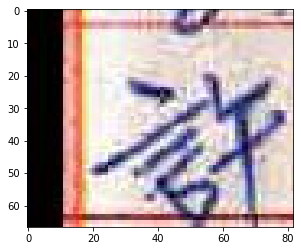


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 連 ( 99.5 % ),  
    正解： 連 
    


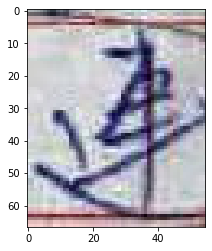


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 陳 ( 100.0 % ),  
    正解： 陳 
    


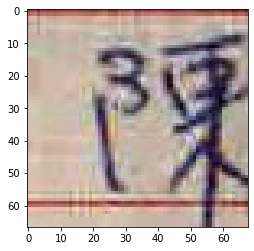


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 興 ( 55.7 % ),  
    正解： 撕 (isnull)
    


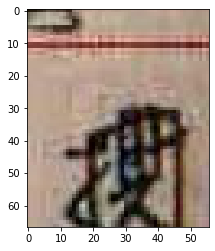


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 翠 ( 57.9 % ),  
    正解： 鞏 (isnull)
    


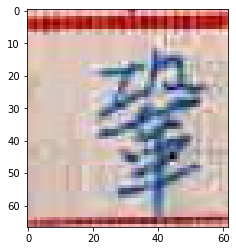


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 黃 ( 100.0 % ),  
    正解： 黃 
    


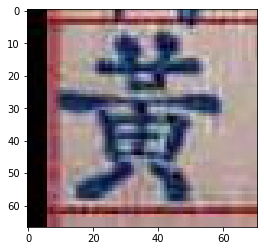


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 靜 ( 63.2 % ),  
    正解： 群 
    


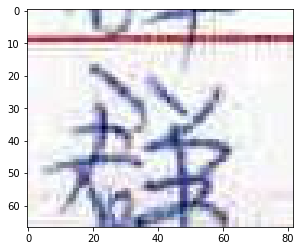


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 詹 ( 100.0 % ),  
    正解： 詹 
    


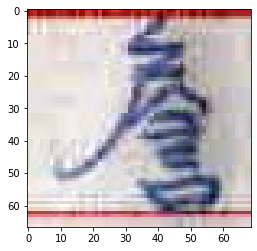


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 圓 ( 70.2 % ),  
    正解： 鳳 
    


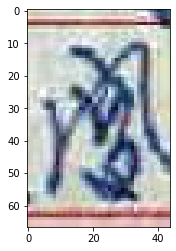


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 賢 ( 99.9 % ),  
    正解： 賢 
    


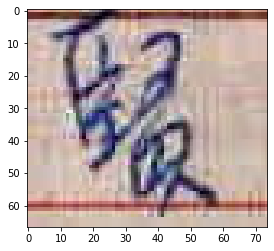


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 憲 ( 99.9 % ),  
    正解： 憲 
    


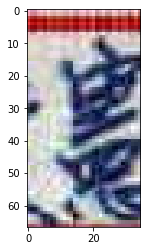


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 興 ( 100.0 % ),  
    正解： 興 
    


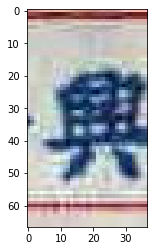


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 駿 ( 99.9 % ),  
    正解： 駖 (isnull)
    


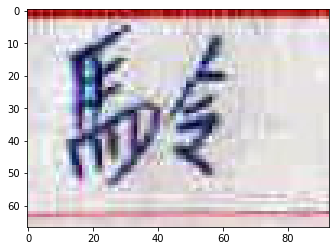


    ---   ---   ---   ---   ---   ---   ---   ---   ---   


In [27]:
for p in test_data_4: # test_data_1 或 test_data_2 自行切換
    img = io.imread(p)
    character = get_character_from_path(p)
    predict_and_show(img=img, model=model, idx2vocab=idx2vocab, character=character, transform=test_transform)

In [12]:
# for p in test_data_2: # test_data_1 或 test_data_2 自行切換
#     img = io.imread(p)
#     character = get_character_from_path(p)
#     predict_and_show(img=img, model=model, idx2vocab=idx2vocab, character=character, transform=test_transform)

In [13]:
# for p in test_data_3: # test_data_1 或 test_data_2 自行切換
#     img = io.imread(p)
#     character = get_character_from_path(p)
#     predict_and_show(img=img, model=model, idx2vocab=idx2vocab, character=character, transform=test_transform)

## 彥庭的模型測試

In [17]:
## 彥庭的 Setting
## Source：玉山 API/api/predict.py

############### 前置作業 ###############
# 讀取字對應的分類編號
wordClassDict = json.load(open(YT_MODEL_SAVE_PATH/'wordClassDict.json', 'r'))

# 分類數量
num_classes = len(list(wordClassDict.keys()))

# 讀取模型架構
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224

# 讀取已訓練好的模型權重
modelWeightFilePath = YT_MODEL_SAVE_PATH/'20210607_model_weight.zip'
model_ft.load_state_dict(torch.load(modelWeightFilePath, map_location=torch.device('cpu')))
#######################################

_test_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
def test_transform(img):
    img = Image.fromarray(img)
    return _test_transform(img)

vocab2idx = wordClassDict
idx2vocab = {v: k for k, v in vocab2idx.items()}
idx2vocab[-1] = "isnull"

model_ft.fc = nn.Sequential(  # 為了預測機率，擅自加上 LogSoftmax
            model_ft.fc,
            nn.LogSoftmax(dim=1)
        )
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
hit_count_1, all_count_1 = calculate_test_data(data=test_data_1, model=model_ft, idx2vocab=idx2vocab, transform=test_transform)
hit_count_2, all_count_2 = calculate_test_data(data=test_data_2, model=model_ft, idx2vocab=idx2vocab, transform=test_transform)
hit_count_3, all_count_3 = calculate_test_data(data=test_data_3, model=model_ft, idx2vocab=idx2vocab, transform=test_transform)
hit_count_4, all_count_4 = calculate_test_data(data=test_data_4, model=model_ft, idx2vocab=idx2vocab, transform=test_transform)
print(f"玉山 2021-05-24 測資\n \
        - 正確率：{hit_count_1/all_count_1*100:.1f} %  ( {hit_count_1} / {all_count_1} )")
print(f"快車肉乾 測資\n \
        - 正確率：{hit_count_2/all_count_2*100:.1f} %  ( {hit_count_2} / {all_count_2} )")
print(f"玉山 2021-05-25 測資\n \
        - 正確率：{hit_count_3/all_count_3*100:.1f} %  ( {hit_count_3} / {all_count_3} )")
print(f"玉山 2021-06-08 測資\n \
        - 正確率：{hit_count_4/all_count_4*100:.1f} %  ( {hit_count_4} / {all_count_4} )")
print(f"上述所有測資加總\n \
        - 正確率：{(hit_count_1+hit_count_2+hit_count_3+hit_count_4)/(all_count_1+all_count_2+all_count_3+all_count_4)*100:.1f} %  ( {hit_count_1+hit_count_2+hit_count_3+hit_count_4} / {all_count_1+all_count_2+all_count_3+all_count_4} )")

玉山 2021-05-24 測資
         - 正確率：77.1 %  ( 27 / 35 )
快車肉乾 測資
         - 正確率：37.3 %  ( 57 / 153 )
玉山 2021-05-25 測資
         - 正確率：80.0 %  ( 28 / 35 )
玉山 2021-06-08 測資
         - 正確率：83.3 %  ( 25 / 30 )
上述所有測資加總
         - 正確率：54.2 %  ( 137 / 253 )



    答對了嗎： True,  
    預測： 文 ( 99.7 % ),  
    正解： 文 
    


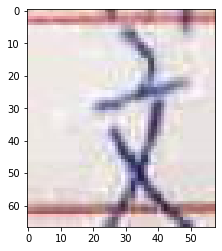


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 石 ( 86.4 % ),  
    正解： 石 
    


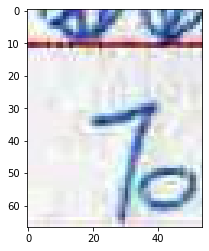


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 丞 ( 99.2 % ),  
    正解： 丞 
    


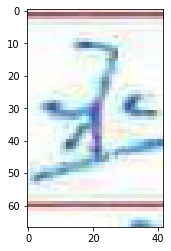


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 余 ( 92.5 % ),  
    正解： 余 
    


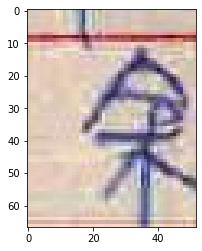


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 呂 ( 100.0 % ),  
    正解： 呂 
    


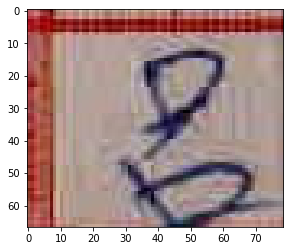


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 邱 ( 56.8 % ),  
    正解： 婭 (isnull)
    


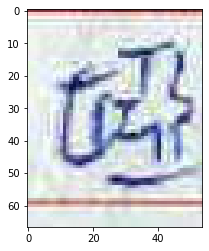


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 兒 ( 99.8 % ),  
    正解： 兒 
    


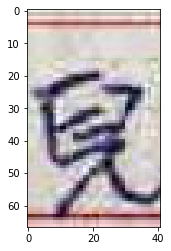


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 坤 ( 100.0 % ),  
    正解： 坤 
    


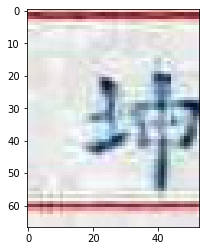


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 尚 ( 100.0 % ),  
    正解： 尚 
    


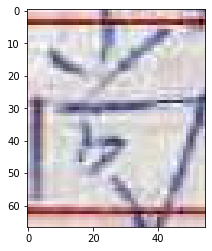


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 忠 ( 100.0 % ),  
    正解： 忠 
    


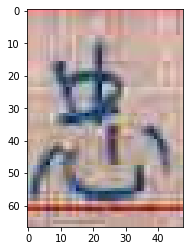


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 宥 ( 100.0 % ),  
    正解： 宥 
    


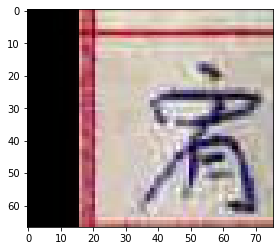


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 施 ( 100.0 % ),  
    正解： 施 
    


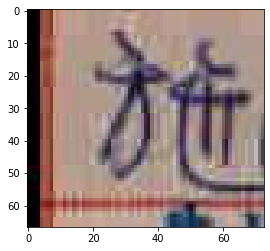


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 春 ( 99.2 % ),  
    正解： 春 
    


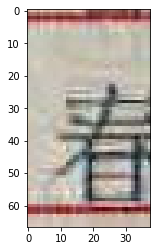


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 凌 ( 100.0 % ),  
    正解： 凌 
    


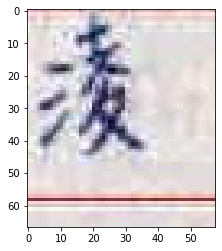


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 哲 ( 100.0 % ),  
    正解： 哲 
    


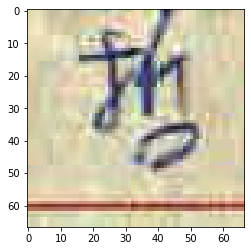


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 震 ( 39.1 % ),  
    正解： 宸 
    


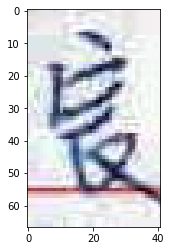


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 敏 ( 99.6 % ),  
    正解： 敏 
    


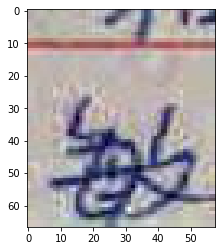


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 許 ( 100.0 % ),  
    正解： 許 
    


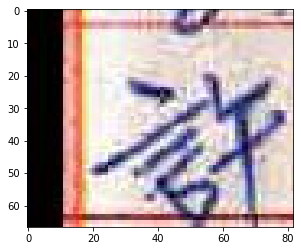


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 連 ( 99.9 % ),  
    正解： 連 
    


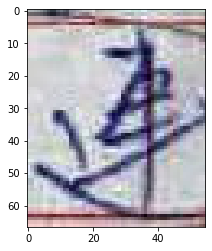


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 陳 ( 100.0 % ),  
    正解： 陳 
    


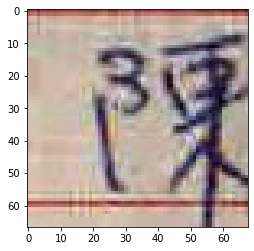


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 博 ( 48.9 % ),  
    正解： 撕 (isnull)
    


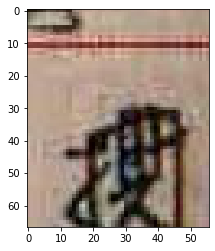


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 華 ( 99.8 % ),  
    正解： 鞏 (isnull)
    


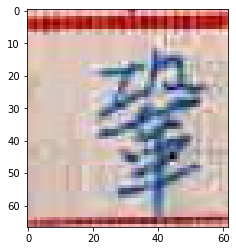


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 黃 ( 100.0 % ),  
    正解： 黃 
    


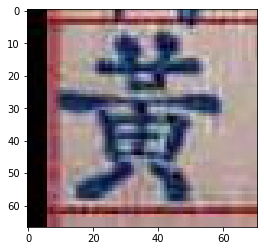


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 群 ( 100.0 % ),  
    正解： 群 
    


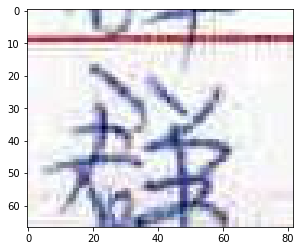


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 詹 ( 100.0 % ),  
    正解： 詹 
    


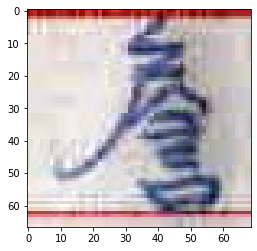


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 鳳 ( 95.0 % ),  
    正解： 鳳 
    


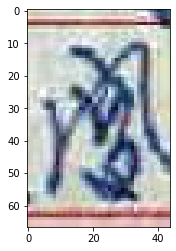


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 賢 ( 98.1 % ),  
    正解： 賢 
    


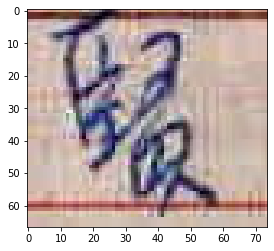


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 憲 ( 54.0 % ),  
    正解： 憲 
    


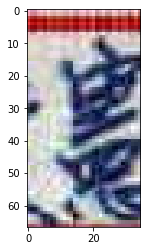


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： True,  
    預測： 興 ( 98.7 % ),  
    正解： 興 
    


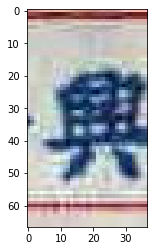


    ---   ---   ---   ---   ---   ---   ---   ---   ---   

    答對了嗎： False,  
    預測： 駿 ( 100.0 % ),  
    正解： 駖 (isnull)
    


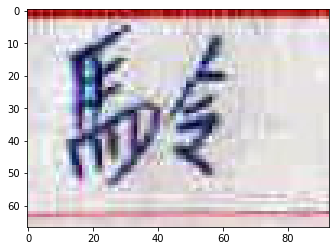


    ---   ---   ---   ---   ---   ---   ---   ---   ---   


In [19]:
for p in test_data_4: # test_data_1 或 test_data_2 自行切換
    img = io.imread(p)
    character = get_character_from_path(p)
    predict_and_show(img=img, model=model_ft, idx2vocab=idx2vocab, character=character, transform=test_transform)

In [20]:
# for p in test_data_2: # test_data_1 或 test_data_2 自行切換
#     img = io.imread(p)
#     character = get_character_from_path(p)
#     predict_and_show(img=img, model=model_ft, idx2vocab=idx2vocab, character=character, transform=test_transform)

In [21]:
# for p in test_data_3: # test_data_1 或 test_data_2 自行切換
#     img = io.imread(p)
#     character = get_character_from_path(p)
#     predict_and_show(img=img, model=model_ft, idx2vocab=idx2vocab, character=character, transform=test_transform)